In [2]:
def symbolic_sequence_f(orbit, num_partitions):

    def split_partitions(num_partitions):
        symbols = list(range(1, num_partitions + 1))
        partitions = []

        partition_points = np.linspace(0, 1, num_partitions + 1)

        for i in range(num_partitions):
            start = partition_points[i]
            end = partition_points[i + 1]
            symbol = symbols[i]
            partitions.append((start, end, symbol))
        return partitions


    sequence = []
    partitions = split_partitions(num_partitions)

    for x in orbit:
        
        # Determinar en qué partición cae x y agregar el símbolo correspondiente
        for (start, end, symbol) in partitions:
            if start <= x < end:
                sequence.append(symbol)
                break

    return sequence

In [3]:
def J_bivariante(X,Y,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [4]:
import numpy as np

def lyapunov_exponent_from_henon_orbit(xs, ys, a, b):
    # Vectores de perturbación iniciales
    v1, v2 = np.array([1.0, 0.0]), np.array([0.0, 1.0])  

    sum_ln1, sum_ln2 = 0.0, 0.0  # Sumas para los exponentes de Lyapunov
    n = len(xs)
    
    for i in range(n):
        # Derivadas parciales del mapa de Henon
        dfdx = -2 * a * xs[i]
        dfdy = 1
        dgdx = b
        dgdy = 0
        
        # Matriz jacobiana del mapa de Henon
        J = np.array([[dfdx, dfdy],
                      [dgdx, dgdy]])
        
        # Aplicar la matriz jacobiana a los vectores de perturbación
        v1 = np.dot(J, v1)
        v2 = np.dot(J, v2)

        # Gram-Schmidt ortogonalización
        v1_norm = np.linalg.norm(v1)
        v1 = v1 / v1_norm
        
        v2_proj = np.dot(v1, v2) * v1  # Proyección de v2 sobre v1
        v2 = v2 - v2_proj
        v2_norm = np.linalg.norm(v2)
        v2 = v2 / v2_norm
        
        # Actualizar las sumas de los logaritmos de los cocientes
        sum_ln1 += np.log(v1_norm)
        sum_ln2 += np.log(v2_norm)

    # Cálculo de los exponentes de Lyapunov
    le1 = sum_ln1 / n
    le2 = sum_ln2 / n

    return max(le1, le2)

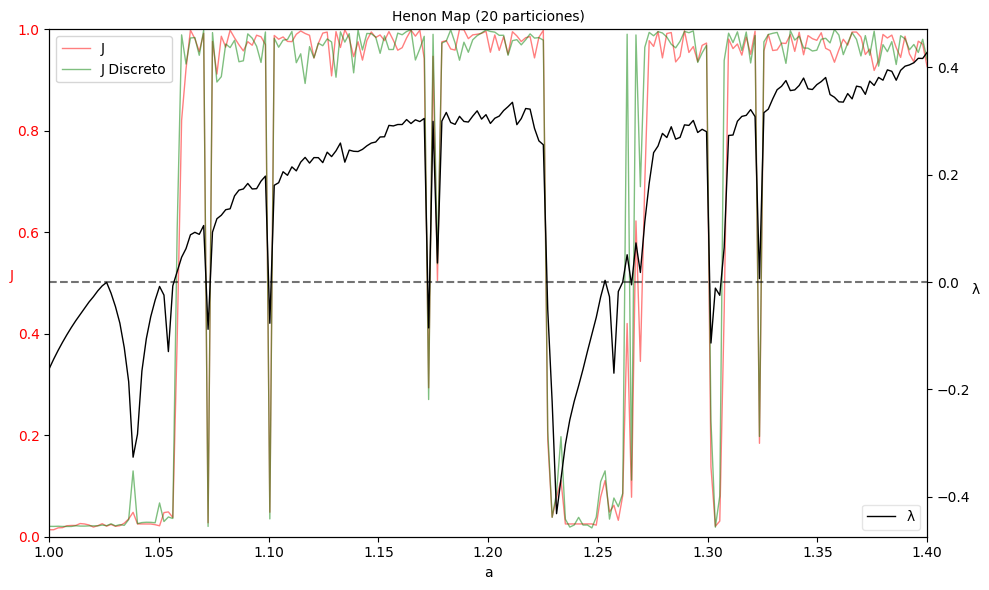

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def henon_map(a, b, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    
    xs[0] = 0.1
    ys[0] = 0.1
    
    for i in range(1, n):
        xs[i] = 1 - a * xs[i-1]**2 + ys[i-1]
        ys[i] = b * xs[i-1]
    
    return xs, ys

partitions = 20

lyapunov = [] 
Js, Js_discreto = [],[]
a_array = np.linspace(1,1.4, 200)
for a in a_array: 
    xs, ys = henon_map(a, 0.3, 2000)
    xs_discreto = symbolic_sequence_f(xs,partitions)
    ys_discreto = symbolic_sequence_f(ys,partitions)
    lyapunov_exponent = lyapunov_exponent_from_henon_orbit(xs, ys, a, 0.3)        
    lyapunov.append(lyapunov_exponent)
    J = J_bivariante(xs,ys,len(xs))
    J_discreto = J_bivariante(xs_discreto,ys_discreto,len(xs_discreto))
    Js.append(J)
    Js_discreto.append(J_discreto)

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(a_array, Js, color = 'red',linewidth=1, alpha = 0.5, label = 'J')
ax1.plot(a_array, Js_discreto, color = 'green',linewidth=1, alpha = 0.5, label = 'J Discreto')
ax1.set_ylabel('J', color='r', rotation = 360)
ax1.set_ylim(0,1)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel('a')
ax1.legend()

ax2 = ax1.twinx()
ax2.axhline(y=0, color='black', linestyle='--', alpha = 0.55)
ax2.plot(a_array, lyapunov,'black',linewidth= 1, label = 'λ')
ax2.legend(loc='lower right',framealpha=0.5)
ax2.set_ylabel('λ', rotation = 360)
plt.title(f'Henon Map ({partitions} particiones)', fontsize = 10)
ax2.set_xlim(1, 1.4)
plt.tight_layout()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

corr_J_discret_list = []

def henon_map(a, b, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    
    xs[0] = 0.1
    ys[0] = 0.1
    
    for i in range(1, n):
        xs[i] = 1 - a * xs[i-1]**2 + ys[i-1]
        ys[i] = b * xs[i-1]
    
    return xs, ys


a_array = np.linspace(1,1.4, 200)
splits = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000]
# splits = [3500, 4000, 4500, 5000]
for split in splits:
    lyapunov, lyapunov_discreto = [], []
    Js, Js_discreto = [],[]
    for a in a_array: 
        xs, ys = henon_map(a, 0.3, 2000)
        xs_discreto = symbolic_sequence_f(xs,split)
        ys_discreto = symbolic_sequence_f(ys,split)     
        J = J_bivariante(xs,ys,len(xs))
        J_discreto = J_bivariante(xs_discreto,ys_discreto,len(xs_discreto))
        Js.append(J)
        Js_discreto.append(J_discreto)
    
    # Js y Js_discreto ya fue calculado

    data = pd.DataFrame({'Js':Js,
        'Js_discreto':Js_discreto})

    corr_spearman = data.corr(method='spearman')

    corr_J_discret_list.append(corr_spearman.loc['Js','Js_discreto'])

np.savetxt('henon_correlations2.txt', corr_J_discret_list, delimiter=',')


In [12]:
g = np.array([3,5])
gg = np.array([1,2])
print(np.concatenate((g,gg)))

[3 5 1 2]


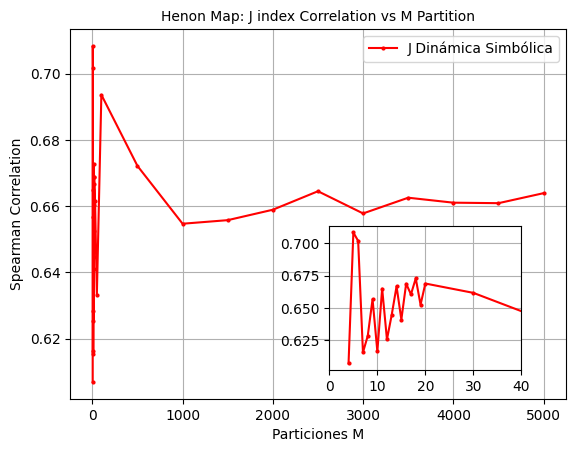

In [13]:
x = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000, 3500, 4000, 4500, 5000]
corr_J_discret_list = np.concatenate((np.loadtxt('henon_correlations.txt', delimiter=',', unpack=True),np.loadtxt('henon_correlations2.txt', delimiter=',', unpack=True)))

# Crear la gráfica principal
fig, ax = plt.subplots()
ax.plot(x,corr_J_discret_list, label = 'J Dinámica Simbólica',markersize = 4, color = 'red', marker='.', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.17, 0.30, 0.30])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_J_discret_list, color='red',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.set_xlim(0, 40)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('Henon Map: J index Correlation vs M Partition', fontsize=10)
ax.legend()
plt.show()

# np.savetxt('henon_correlations.txt', np.column_stack((corr_lyapunov_discret_list, corr_J_discret_list)), delimiter=',')
